In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from text_clean import *

import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import pandas as pd

analyser = SentimentIntensityAnalyzer()

def label_stocks(row):
    if row['Close'] >= row['yesterday_close']:
        return 1
    else:
        return 0

def label_sentiment(row):
    sent = analyser.polarity_scores(row['text'])
    return pd.Series([sent['neg'], sent['neu'], sent['pos'], sent['compound']])

    

# File paths
apple_stocks = "Data/Stock data/aapl_indicators.us.txt"
amazon_stocks = "Data/Stock data/amzn_indicators.us.txt"
facebook_stocks = "Data/Stock data/fb_indicators.us.txt"

apple_headlines = "Data/News data/apple_deduped.csv"
amazon_headlines = "Data/News data/amazon_deduped.csv"
facebook_headlines = "Data/News data/facebook_deduped.csv"

apple_reddit = "Data/News data/apple_reddit.csv"
amazon_reddit = "Data/News data/amazon_reddit.csv"
facebook_reddit = "Data/News data/facebook_reddit.csv"

apple_tweets = "Data/Tweets/apple_tweets.csv"
amazon_tweets = "Data/Tweets/amazon_tweets.csv"
facebook_tweets = "Data/Tweets/facebook_tweets.csv"

# Twitter date parser
mydateparser = lambda x: pd.datetime.strptime(x[:10] + " " + x[-4:], "%a %b %d %Y")

# Read in text data and stock data
df3 = pd.read_csv(apple_tweets, parse_dates=[1], date_parser=mydateparser)
df1 = pd.read_csv(apple_reddit, parse_dates=[1])
df2 = pd.read_csv(apple_headlines, parse_dates=[1])
df = pd.concat([df1, df2, df3], axis=0, join='inner', ignore_index=True)

In [26]:
df = df.set_index(['Date'])

# Limit to 50 headlines per day
df_new = pd.DataFrame()

for _, group in df.groupby(df.index):
    n = 50 if len(group) >= 50 else len(group)
    df_new = pd.concat([df_new, group.sample(n)])
    
df = df_new

# Use NLTK VADER to add sentiment features
df[['neg', 'neu', 'pos', 'compound']] =  df.apply(label_sentiment, axis=1)

# Read stock in and use yesterday's TI as features
stock = pd.read_csv(apple_stocks, parse_dates=[0])
# stock = ta.add_all_ta_features(stock, 'Open', 'High', 'Low', 'Close', 'Volume', fillna=True)
stock['yesterday_close'] = stock['Close'].shift()
stock['value'] = stock.apply(lambda row: label_stocks(row), axis=1)

stock.loc[:, 'High':'yesterday_close'] = stock.loc[:, 'High':'yesterday_close'].shift()

In [27]:
# Rename twitter columns if necessary
# df.rename({'created_at': 'Date'}, inplace=True, axis=1)
# df.drop('user_id_str', axis=1, inplace=True)
df = pd.merge(df, stock, on="Date", how="inner")
df.drop('Close', axis=1, inplace=True)

"""
BALANCE CLASSES
"""
# Class count
count_class_1, count_class_0 = df.value.value_counts()

# Divide by class
df_class_0 = df[df['value'] == 0]
df_class_1 = df[df['value'] == 1]

if count_class_1 > count_class_0:
    df_class_1_under = df_class_1.sample(count_class_0)
    df = pd.concat([df_class_1_under, df_class_0], axis=0)
else:
    df_class_0_under = df_class_0.sample(count_class_1)
    df = pd.concat([df_class_0_under, df_class_1], axis=0)
    

df = df.set_index(['Date'])
df.sort_index(inplace=True)

In [28]:
# Scale numeric data
scaler = StandardScaler()
df.loc[:, 'neg': 'yesterday_close'] = scaler.fit_transform(df.loc[:, 'neg': 'yesterday_close'])

In [12]:
df

,text,neg,neu,pos,compound,Open,High,Low,Volume,volume_adi,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,yesterday_close,value
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-31,Apple Denies Working With NSA On iPhone Backdoor,2.181667,-1.048055,-0.597803,-1.582462,-1.667040,-1.655097,-1.637288,0.226670,-1.292339,...,-0.210759,-0.345148,0.179803,-0.345148,0.351168,-0.676935,-0.671428,-1.662141,-1.610010,1
2013-12-31,"No, Apple Does Not Help the NSA Hack iPhones",3.138267,-1.716581,-0.597803,-1.967066,-1.667040,-1.655097,-1.637288,0.226670,-1.292339,...,-0.210759,-0.345148,0.179803,-0.345148,0.351168,-0.676935,-0.671428,-1.662141,-1.610010,1
2014-01-02,$ aapl us stocks-wall st kicks off new year on...,1.076469,-0.275681,-0.597803,-1.160171,-1.655537,-1.646127,-1.624257,-0.054495,0.391921,...,0.431817,0.318122,0.073195,0.318122,0.249468,0.684873,0.687880,-1.612207,-1.652744,0
2014-01-02,i bought a new tv this year . would probably h...,-0.474523,-0.139379,0.590743,1.707707,-1.655537,-1.646127,-1.624257,-0.054495,0.391921,...,0.431817,0.318122,0.073195,0.318122,0.249468,0.684873,0.687880,-1.612207,-1.652744,0
2014-01-02,$ aapl let's not let the wf downgrade overshad...,-0.474523,0.185148,0.183707,0.516544,-1.655537,-1.646127,-1.624257,-0.054495,0.391921,...,0.431817,0.318122,0.073195,0.318122,0.249468,0.684873,0.687880,-1.612207,-1.652744,0
2014-01-02,what are your top picks for q1 2014 ? here are...,-0.474523,0.113752,0.273255,0.516544,-1.655537,-1.646127,-1.624257,-0.054495,0.391921,...,0.431817,0.318122,0.073195,0.318122,0.249468,0.684873,0.687880,-1.612207,-1.652744,0
2014-01-02,emylers : cheeky's board ! : $ aapl up to date...,-0.474523,0.808240,-0.597803,-0.164169,-1.655537,-1.646127,-1.624257,-0.054495,0.391921,...,0.431817,0.318122,0.073195,0.318122,0.249468,0.684873,0.687880,-1.612207,-1.652744,0
2014-01-02,"rt AT_USER apple slips , urban outfitters up o...",-0.474523,0.808240,-0.597803,-0.164169,-1.655537,-1.646127,-1.624257,-0.054495,0.391921,...,0.431817,0.318122,0.073195,0.318122,0.249468,0.684873,0.687880,-1.612207,-1.652744,0
2014-01-02,this weeks $ aapl 550 puts are already up a do...,-0.474523,0.808240,-0.597803,-0.164169,-1.655537,-1.646127,-1.624257,-0.054495,0.391921,...,0.431817,0.318122,0.073195,0.318122,0.249468,0.684873,0.687880,-1.612207,-1.652744,0


Preprocess and split data into train and test sets

In [29]:
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x.loc[:, 'Open': 'Volume'], validate=False)

# df['text'] = df['text'].str.replace('[^\w\s]',' ')

# X = features, y = class labels
X = df.loc[:, 'text': 'yesterday_close']
y = df.loc[:, 'value']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Avoid having same days in train and test set
# X_train, y_train = X.loc[:'2015-07-26'], y.loc[:'2015-07-26']
# X_test, y_test = X.loc['2015-07-26':], y.loc['2015-07-26':]

In [32]:
from sklearn.dummy import DummyClassifier
# Create model and vectorizer
vect = TfidfVectorizer(analyzer='word', stop_words='english', strip_accents='unicode', ngram_range=(1, 3), max_features=500)

model = Pipeline([
    ('features', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data)
                ])),
#                   ('text_features', Pipeline([
#                      ('selector', get_text_data),
#                      ('vec',  vect)
#                  ]))
         ])),
    ('clf', LinearSVC(C=10, class_weight='balanced', dual=True, fit_intercept=False, loss='hinge', max_iter=2000, penalty='l2', random_state=42))
    # ('clf', KNeighborsClassifier(n_neighbors=3)),
    # ('clf', LinearSVC(C=10, class_weight='balanced', dual=False, fit_intercept=False, loss='squared_hinge')),
    # ('clf', LinearSVC(class_weight='balanced', fit_intercept=False, penalty='l1', dual=False, C=0.2)),
])

# model.fit(X_train, y_train)
# print(model.score(X_train, y_train))
# y_pred = model.predict(X_test)


# print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
# print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
# print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")

# Grid Search

In [238]:
X_cv = X.reset_index()
y_cv = y.reset_index()
cv_iterator = []
# Cross Validation
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    # Calculate train date range
    train_date_begin = df.index[train_index[0]]
    train_date_end = df.index[train_index[-1]]
    train_date_begin = str(train_date_begin.date())
    train_date_end = str(train_date_end.date())
    
    # Calculate test date range
    test_date_begin = df.index[test_index[0]]
    test_date_end = df.index[test_index[-1]]
    test_date_begin = str(test_date_begin.date())
    test_date_end = str(test_date_end.date())
    
    # Split
    mask_train = ((X_cv['Date'] >= train_date_begin) & (X_cv['Date'] < test_date_begin)) | ((X_cv['Date'] > test_date_end) & (X_cv['Date'] <= train_date_end))
    mask_test = (X_cv['Date'] >= test_date_begin) & (X_cv['Date'] <= test_date_end)
    train_indices = X_cv.loc[mask_train].index.values
    test_indices = X_cv.loc[mask_test].index.values
    cv_iterator.append((train_indices, test_indices))


In [ ]:
model.get_params().keys()

In [ ]:
# Choose some parameter combinations to try
parameters = {'clf__penalty': ['l1', 'l2'], 
              'clf__loss': ['hinge', 'squared_hinge'], 
              'clf__dual': [True, False],
              'clf__C': [0.1, 1, 2, 10, 100], 
              'clf__fit_intercept': [False],
              'clf__random_state': [None, 42],
              'clf__max_iter': [1000, 2000, 3000]
             }

# parameters = {'clf__n_neighbors': [2, 3], 
#               'clf__weights': ['uniform', 'distance'], 
#               'clf__n_jobs': [-1],
#              }


# parameters = {'features__text_features__vec__analyzer': ['word', preprocess_text], 
#               'features__text_features__vec__ngram_range': [(1, 1), (1, 2), (1, 3), (3, 3)]
#              }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(model, parameters, scoring=acc_scorer, n_jobs=-1, error_score=0.0, cv=cv_iterator, verbose=10)
grid_obj = grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

In [241]:
grid_obj.best_params_

{'clf__C': 10,
 'clf__dual': False,
 'clf__fit_intercept': False,
 'clf__loss': 'squared_hinge',
 'clf__max_iter': 1000,
 'clf__penalty': 'l2',
 'clf__random_state': None}

# Cross-validate model

In [41]:
accs = []
f1s = []
cms = []

X_cv = X.reset_index()
y_cv = y.reset_index()
try:
    model = clf
except:
    pass

# Cross Validation
kf = KFold(n_splits=3)
run_num = 0
for train_index, test_index in kf.split(X):
    # Calculate train date range
    train_date_begin = df.index[train_index[0]]
    train_date_end = df.index[train_index[-1]]
    train_date_begin = str(train_date_begin.date())
    train_date_end = str(train_date_end.date())
    
    # Calculate test date range
    test_date_begin = df.index[test_index[0]]
    test_train_left = test_date_begin - pd.DateOffset(1)
    
    test_date_end = df.index[test_index[-1]]
    test_train_right = test_date_end + pd.DateOffset(1)
    
    test_date_begin = str(test_date_begin.date())
    test_date_end = str(test_date_end.date())
    print(f"Run #{run_num}")
    print(test_date_begin)
    print(test_date_end)
    
    # Split
    #X_train, X_test = pd.concat([X.loc[train_date_begin:test_train_left], X.loc[test_train_right:train_date_end]]), X.loc[test_date_begin:test_date_end]
    #y_train, y_test = pd.concat([y.loc[train_date_begin:test_train_left], y.loc[test_train_right:train_date_end]]), y.loc[test_date_begin:test_date_end]
    mask_train = ((X_cv['Date'] >= train_date_begin) & (X_cv['Date'] < test_date_begin)) | ((X_cv['Date'] > test_date_end) & (X_cv['Date'] <= train_date_end))
    mask_test = (X_cv['Date'] >= test_date_begin) & (X_cv['Date'] <= test_date_end)
    X_train, X_test = X_cv.loc[mask_train].loc[:, 'text':], X_cv.loc[mask_test].loc[:, 'text':]
    y_train, y_test = y_cv.loc[mask_train]['value'], y_cv.loc[mask_test]['value']
    
    model.fit(X_train, y_train)
    print(f"Model fit: {model.score(X_train, y_train)}")
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Fold accuracy: {accuracy}")
    accs.append(accuracy)
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))
    run_num += 1
# print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
# print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
# print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")

print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))

Run #0
2013-12-31
2014-09-24


f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model fit: 0.6704788607688335
Fold accuracy: 0.5585505965532479
Run #1
2014-09-24
2015-05-19
Model fit: 0.6559905100830368
Fold accuracy: 0.5732419025386636
Run #2
2015-05-19
2015-12-31
Model fit: 0.6519589758725005
Fold accuracy: 0.5925762262483429

Average accuracy across folds: 57.48%

Average F1 score across folds: 59.05%

Average Confusion Matrix across folds: 
 [[1672.33333333 1748.        ]
 [1148.         2242.33333333]]


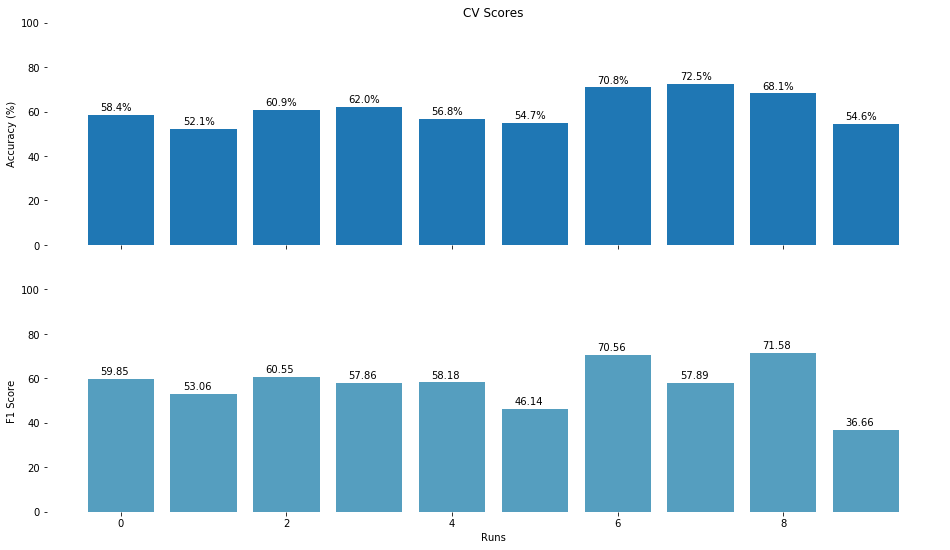

In [20]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,9))

acc_scores = [round(a * 100, 1) for a in accs]
f1_scores = [round(f * 100, 2) for f in f1s]

x1 = np.arange(len(acc_scores))
x2 = np.arange(len(f1_scores))

ax1.bar(x1, acc_scores)
ax2.bar(x2, f1_scores, color='#559ebf')

# Place values on top of bars
for i, v in enumerate(list(zip(acc_scores, f1_scores))):
    ax1.text(i - 0.25, v[0] + 2, str(v[0]) + '%')
    ax2.text(i - 0.25, v[1] + 2, str(v[1]))

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('CV Scores')
ax1.set_ylim([0, 100])

ax2.set_ylabel('F1 Score')
ax2.set_xlabel('Runs')
ax2.set_ylim([0, 100])

sns.despine(bottom=True, left=True)  # Remove the ticks on axes for cleaner presentation

plt.show()

# Graph most influential words:

In [228]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

# model.named_steps['features'].transformer_list[1][1].named_steps['vec']
Xtr = model.named_steps['features'].transformer_list[1][1].named_steps['vec'].fit_transform(X['text'])
features = model.named_steps['features'].transformer_list[1][1].named_steps['vec'].get_feature_names()
feats = top_feats_by_class(Xtr, y, features)

plot_tfidf_classfeats_h(feats)

IndexError: list index out of range

# Plot ROC Curve along with other stats

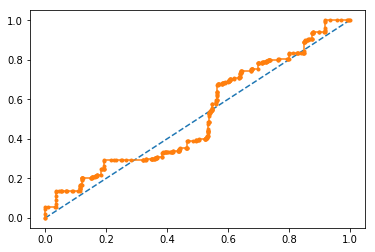

In [19]:
from sklearn.metrics import classification_report, roc_auc_score
from matplotlib import pyplot

def evaluate(classifier):
    predicted = classifier.predict(X_test)
    if isinstance(classifier.steps[1][1], LinearSVC):
        probabilities = np.array(classifier.decision_function(X_test))
        scores = probabilities
    else:
        probabilities = np.array(classifier.predict_proba(X_test))
        scores = probabilities[:, 1]  # NEW

    testing_category_array = np.array(y_test)  # NEW
    pos_idx = np.where(testing_category_array == 1)
    predicted_true_binary = np.zeros(testing_category_array.shape)
    predicted_true_binary[pos_idx] = 1
    fpr, tpr, thresholds = roc_curve(predicted_true_binary, scores)
    auc = roc_auc_score(predicted_true_binary, scores)

    mean_acc = np.mean(predicted == y_test)
    report = classification_report(y_test, predicted)

    return fpr, tpr, auc, mean_acc, report

fpr, tpr, auc, mean_acc, report = evaluate(model)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [38]:
feats = FeatureUnion([
              ('numeric_features', Pipeline([
                  ('selector', get_numeric_data)
              ])),
                ('text_features', Pipeline([
                   ('selector', get_text_data),
                   ('vec',  vect)
               ]))
         ])

data = feats.fit_transform(X_train)

In [ ]:
# indx = np.where(abs(tsvd.components_[0]) <= 0.01)
indx = [0, 1, 2, 3, 12, 20, 21, 25, 26, 29, 30, 31, 32, 42, 46, 47, 55, 63]
X_train.drop(X_train.columns[indx], axis=1)

In [ ]:
tsvd.components_[0]

In [21]:
np.where(abs(tsvd.components_[0]) <= 0.01)

NameError: name 'tsvd' is not defined

In [39]:
from mlxtend.plotting import plot_decision_regions
from sklearn.manifold import TSNE

tsvd = TruncatedSVD(n_components=2)
# tsvd = TSNE(n_components=2, verbose=1)
pca = tsvd.fit(data)
pca_2d = tsvd.transform(data)

f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


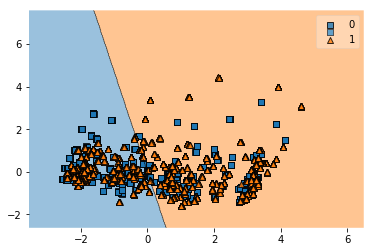

In [40]:
svmClassifier_2d =   model.named_steps['clf'].fit(pca_2d, y_train)


plot_decision_regions(X=pca_2d, y=y_train.values, clf=svmClassifier_2d)